In [1]:
import os
import re

import pandas as pd
import numpy as np

from matplotlib.cbook import boxplot_stats
import matplotlib.pyplot as plt
import seaborn as sns

import util as util
import metrics as mt
from lamp import Lamp
from itertools import product

In [3]:
attributions = {
    1 : {}, 
    5 : {}, 
    6 : {},
    7 : {}, 
    8 : {},
    9 : {},
    10 : {},
    11 : {},
    16 : {},
    17 : {},
}

selected_epochs = [1, 5, 6, 7, 8, 9, 10, 11, 16, 17]

In [4]:
# Diretório onde estão os arquivos .csv
diretorio = './data/wdbc/NN/feature_importance/epochs/'


# Percorre todos os arquivos no diretório
for nome_arquivo in os.listdir(diretorio):
    # Verifica se o arquivo é um arquivo .pt
    if nome_arquivo.endswith('.csv'):
        # Cria o caminho completo para o arquivo
        caminho_arquivo = os.path.join(diretorio, nome_arquivo)
        # Carrega o modelo a partir do arquivo
        attr = pd.read_csv(caminho_arquivo)
        # Add no dicionario
        method = re.search('wdbc_(.+?)_epoch', nome_arquivo)
        epoch = re.search('epoch_(.+?).csv', nome_arquivo)
        #print(method.group(1))
        #print(epoch.group(1))
        attributions[int(epoch.group(1))][method.group(1)] = attr
        # Informa status
        print(f"Feature Importance {nome_arquivo} carregado com sucesso!")

Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_1.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_10.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_11.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_16.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_17.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_5.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_6.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_7.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_8.csv carregado com sucesso!
Feature Importance feature_importance_NN_wdbc_Input_X_Gradient_epoch_9.csv carregado com sucesso!
Feature Importan

In [10]:
explanation_methods = ['Integrated_Gradients',
                       'Input_X_Gradient', 
                       'SmoothGrad',
                       'Vanilla_Gradients', 
#                        'Guided_Backprop',
                       'Occlusion',
                       'Lime', 
                       'KernelShap',
#                        'DeepLift',
                       #'FeatureAblation', 
                       #'FeaturePermutation',
                       'ShapleyValueSampling',
          ]

explanation_methods

['Integrated_Gradients',
 'Input_X_Gradient',
 'SmoothGrad',
 'Vanilla_Gradients',
 'Occlusion',
 'Lime',
 'KernelShap',
 'ShapleyValueSampling']

In [11]:
def get_dict_topk(dict_attributions, list_methods, k=5):
    
    dict_topk = {}
    
    for method_name in list_methods:
        dict_topk[method_name] = mt.get_top_k(dict_attributions[method_name], k)        
    
    return dict_topk

In [12]:
def calc_metrics(ranking_size, methods, metric, dict_topk):
    
    # recuperando apenas o topk dos métodos de explicação indicados
    dict_topk = {k: v for k, v in dict_topk.items() if k in methods}
    
    #num_instancias do dataset
    first_element = next(iter(dict_topk.items()))
    num_instancias = len(first_element[1])
    
    # Matriz de pontos com as combinações dos métodos de explicação para a função feature agreement
    matrix_points, list_combinations_methods = mt.create_matrix_combination_methdos_by_metric(dict_topk, metric, num_instancias, methods)
    
    
    return matrix_points, list_combinations_methods

In [13]:
list_metrics = {
    "feature agreement": mt.feature_agreement,
#     "rank agreement": mt.rank_agreement,
    "sign agreement": mt.sign_agreement,
#     "signed rank agreement": mt.sign_rank_agreement,
}

In [14]:
def draw_lamp(matrix_points, ax):
    
    df_ds = pd.DataFrame(matrix_points)
    n_ds = df_ds.shape[0]
    
    ################### LAMP calc
    # creating the control points
    sample_size = matrix_points.shape[1] #Número de combinações, por enquanto é sempre 6
    table = list(product([0, 1], repeat=sample_size))
    ctp_samples = []
    for i in table:
        ctp_samples.append(list(i))
        
    #transformando os pontos de controle de lista para numpy array
    ctp_samples = np.asarray(ctp_samples)

    control_points_samples = np.array(ctp_samples) #NEW
    df_ctp_5d = pd.DataFrame(control_points_samples)
    n_5d = df_ctp_5d.shape[0]

    cp_positions__ = util.control_points_position_v2(control_points_samples)
    df_ctp_2d = pd.DataFrame(cp_positions__)

    df_ds_cct = pd.concat([df_ds, df_ctp_5d], ignore_index=True)

    ids = np.arange(n_ds,n_ds+n_5d)
    df_ctp_2d[2] = ids

    ctp_2d = df_ctp_2d.values
    data = df_ds_cct.values

    lamp_proj = Lamp(Xdata = data, control_points = ctp_2d, label=False)
    data_proj = lamp_proj.fit()
    cp_positions = np.asarray(cp_positions__)

    #build lamp plot
    size_dataset = len(matrix_points)
    df = pd.DataFrame(data_proj[:size_dataset,:], columns=['Comp_1','Comp_2'])
    df['Class'] = 'Original'
    df2 = pd.DataFrame(cp_positions__, columns=['Comp_1','Comp_2'])
    df2['Class'] = 'Control Point'
    # Filtrando os pontos de controle para mostrar apenas o 0,0 e 1,1
    # Se desejar mostrar todos, basta remover essa linha
    df2 = df2.iloc[[0, len(df2)-1]] 
    
    df = pd.concat([df, df2])
    df = df.reset_index()
    df['Index'] = df.index    
    
    g = sns.scatterplot(data=df, x="Comp_1", y="Comp_2", hue="Class", ax=ax)
    g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
    return g, df
    

# Case 1: Gradient based explanation methods

In [15]:
explanation_methods

['Integrated_Gradients',
 'Input_X_Gradient',
 'SmoothGrad',
 'Vanilla_Gradients',
 'Occlusion',
 'Lime',
 'KernelShap',
 'ShapleyValueSampling']

In [17]:
# attributions[1]['Integrated_Gradients']

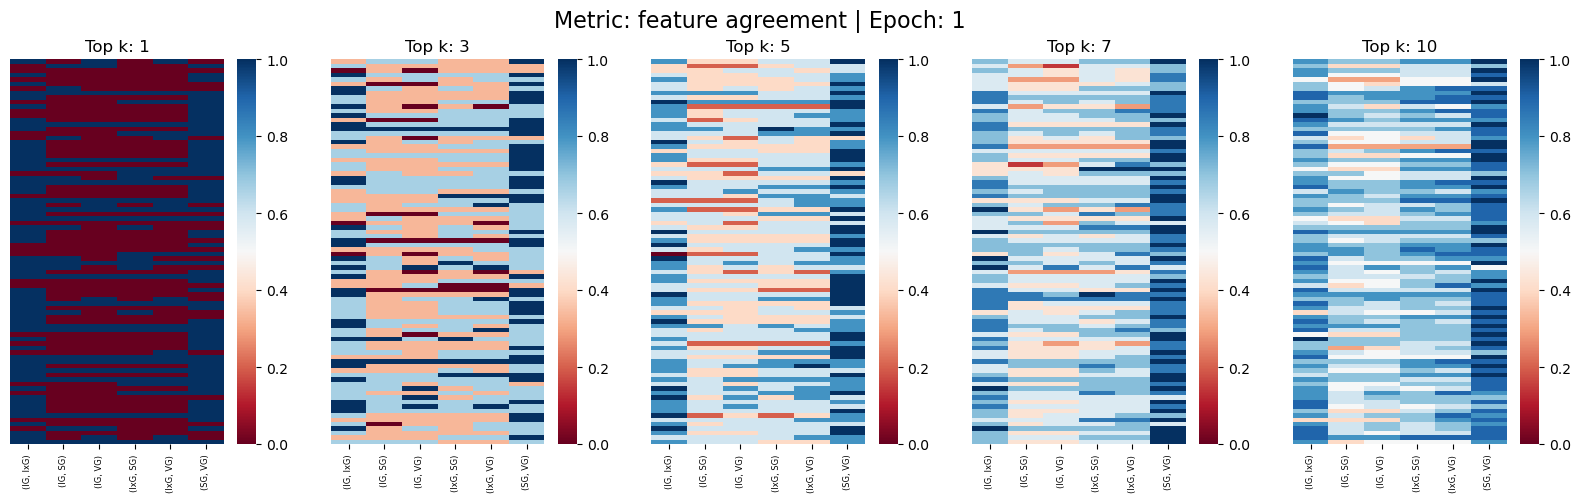

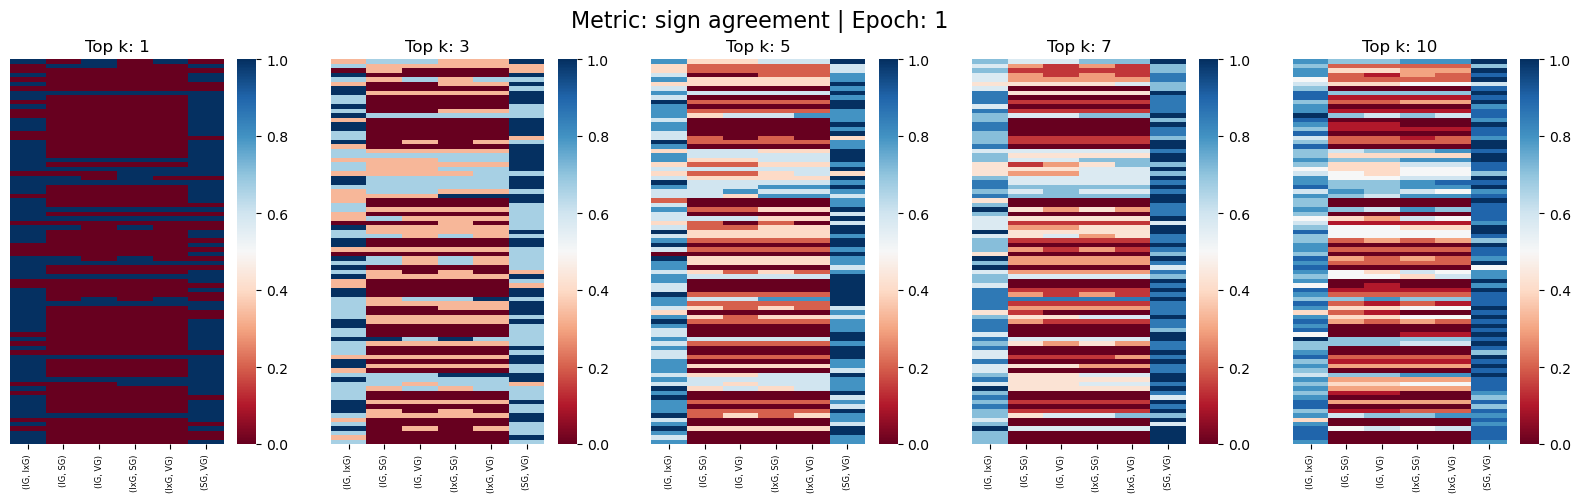

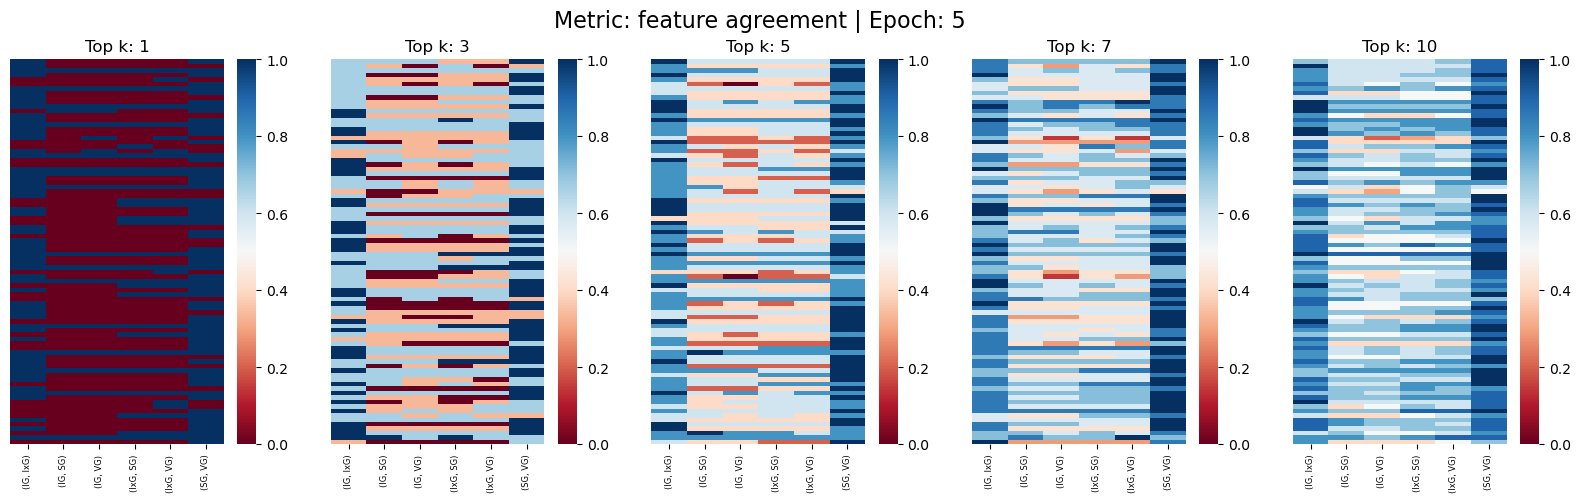

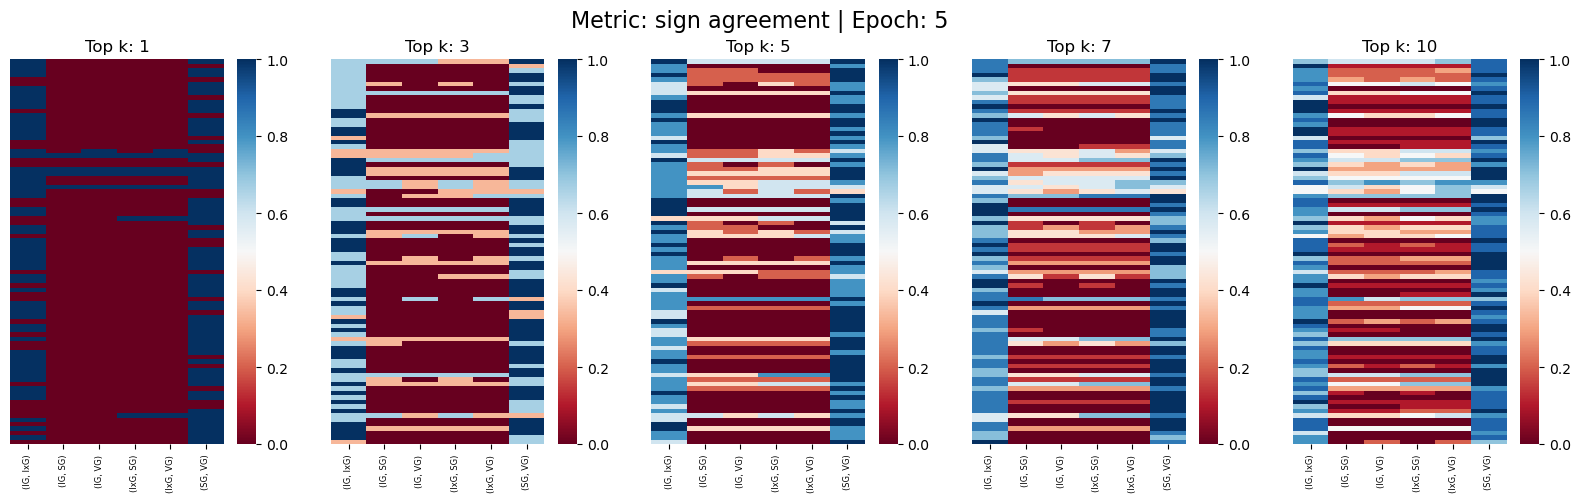

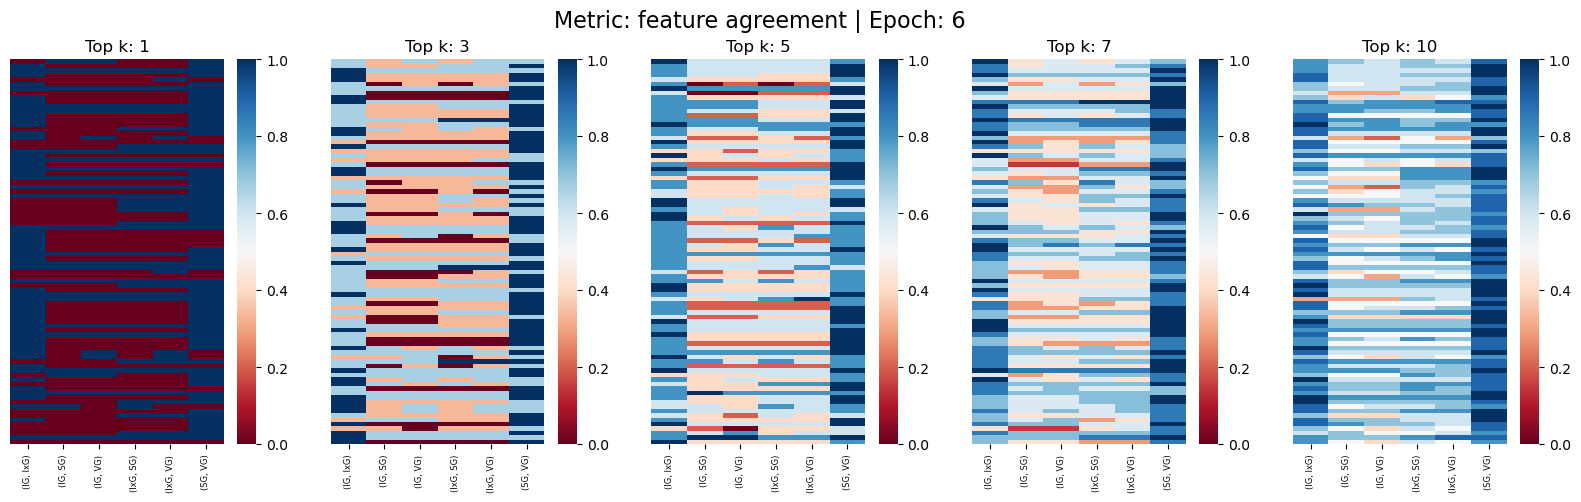

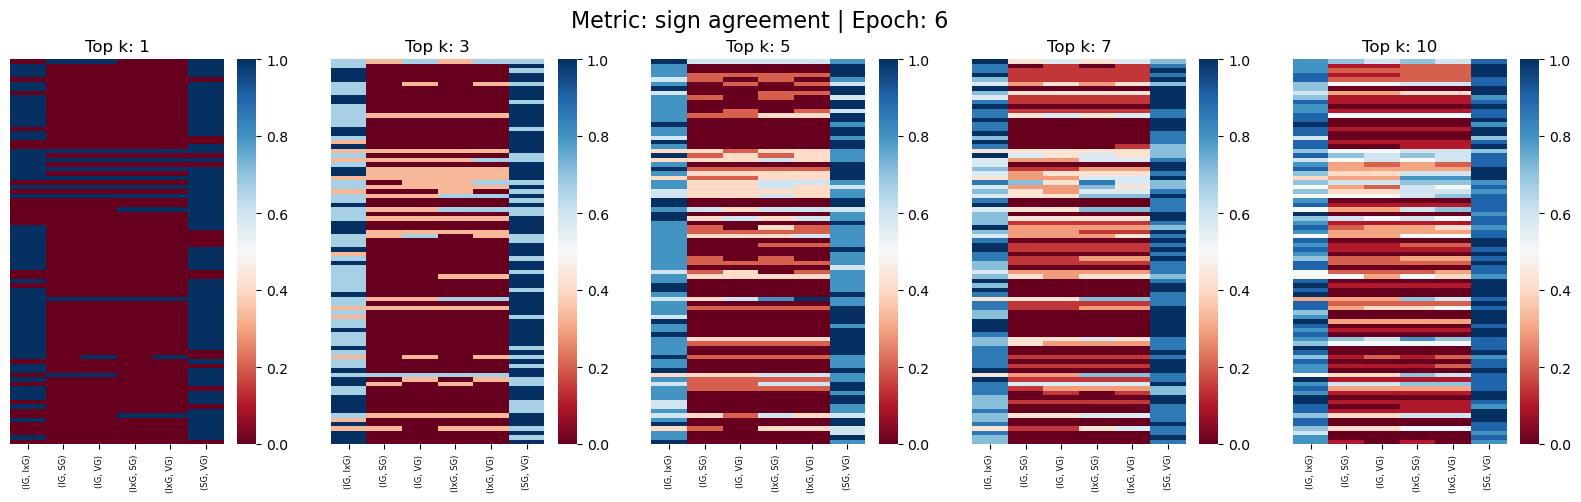

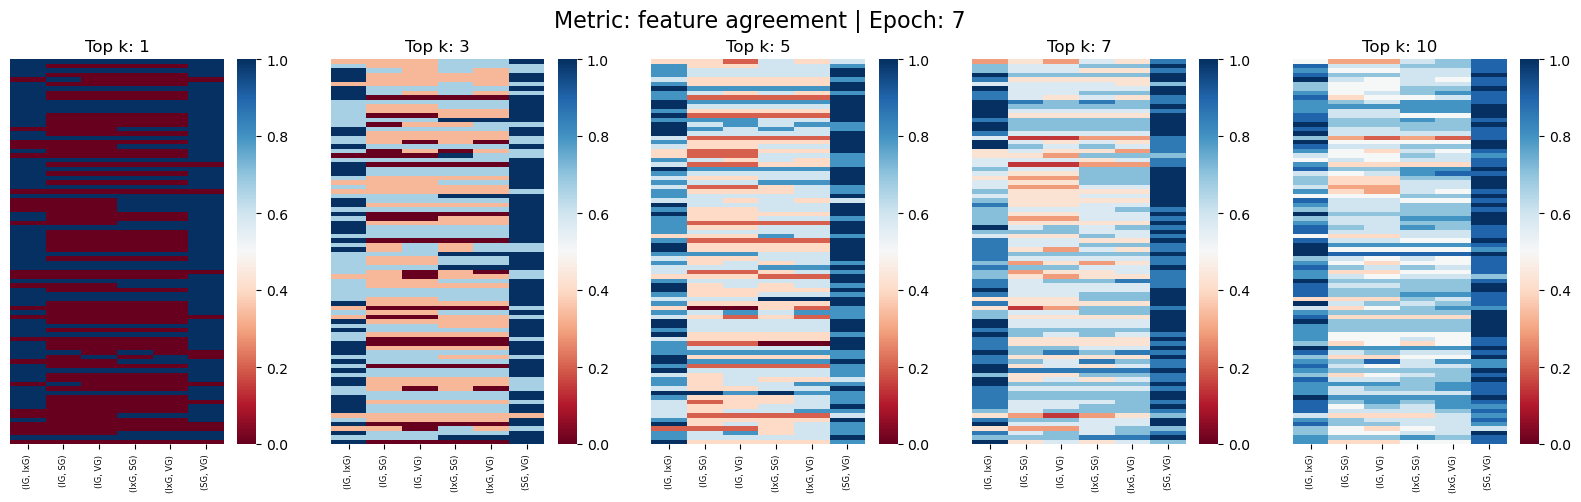

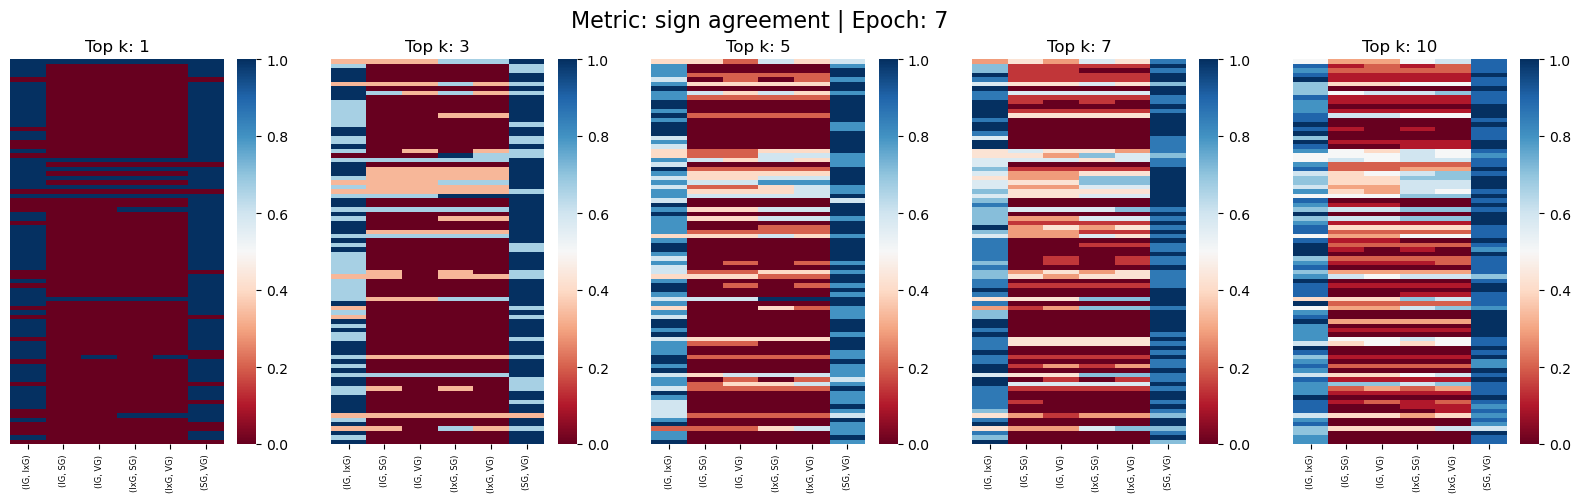

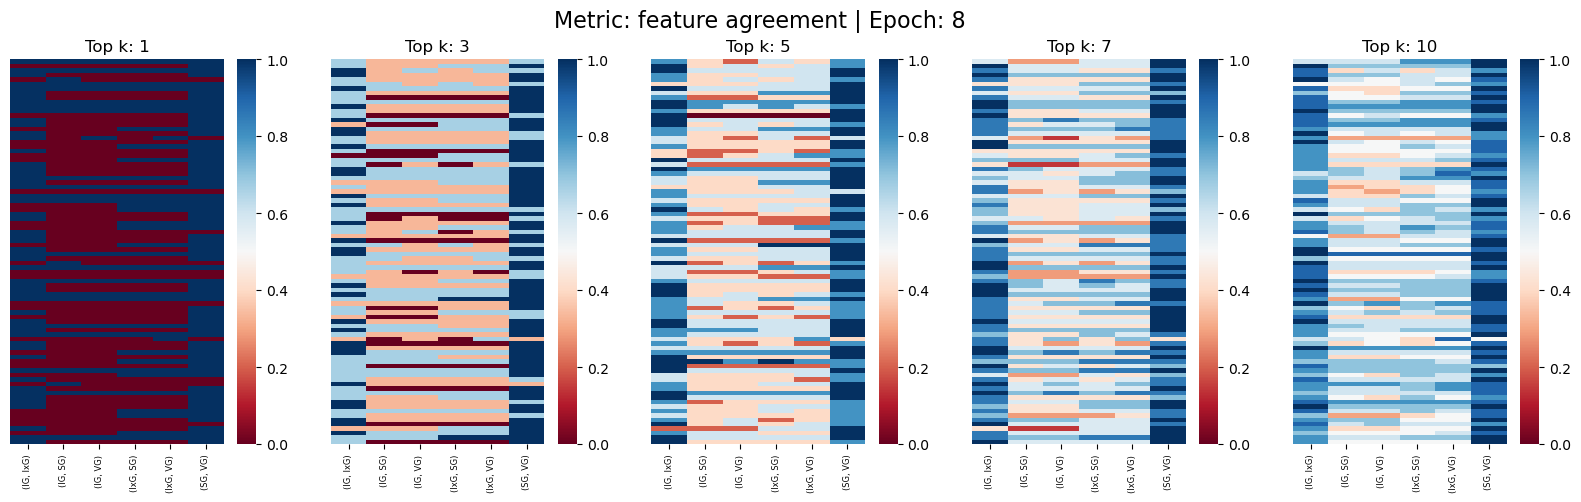

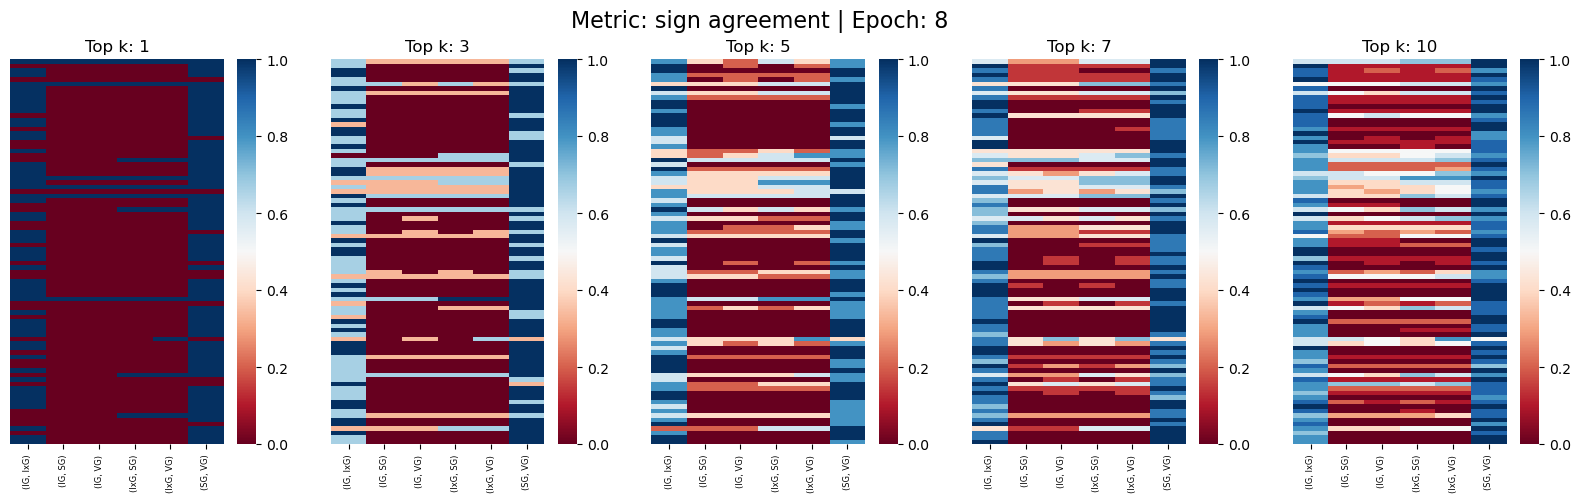

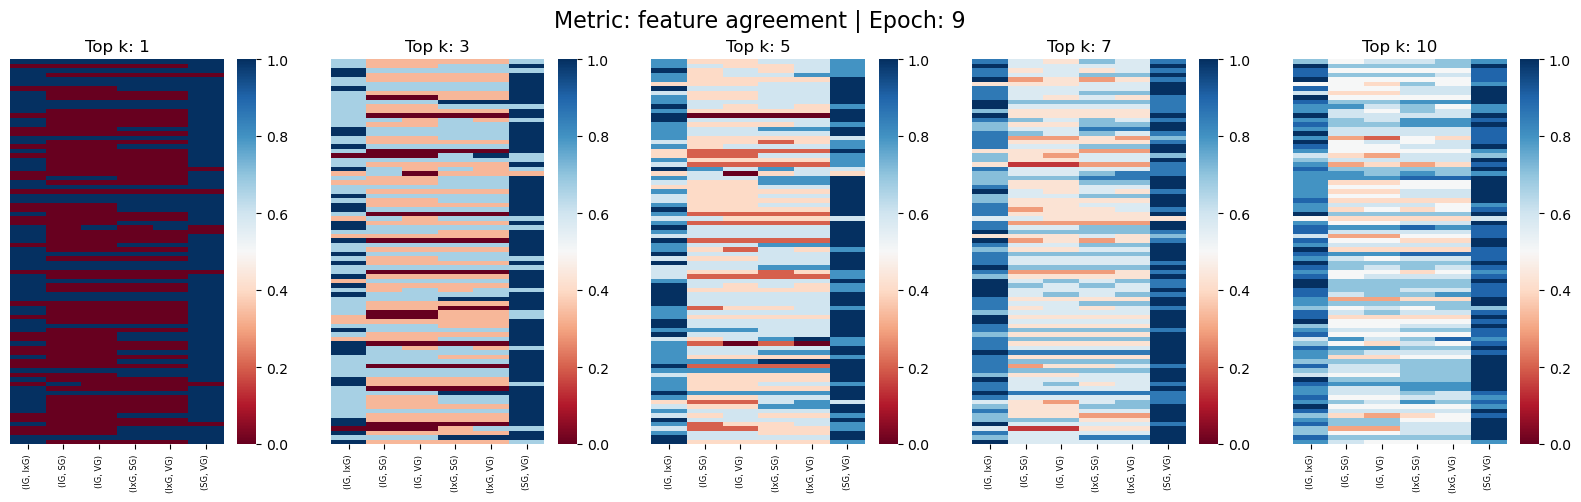

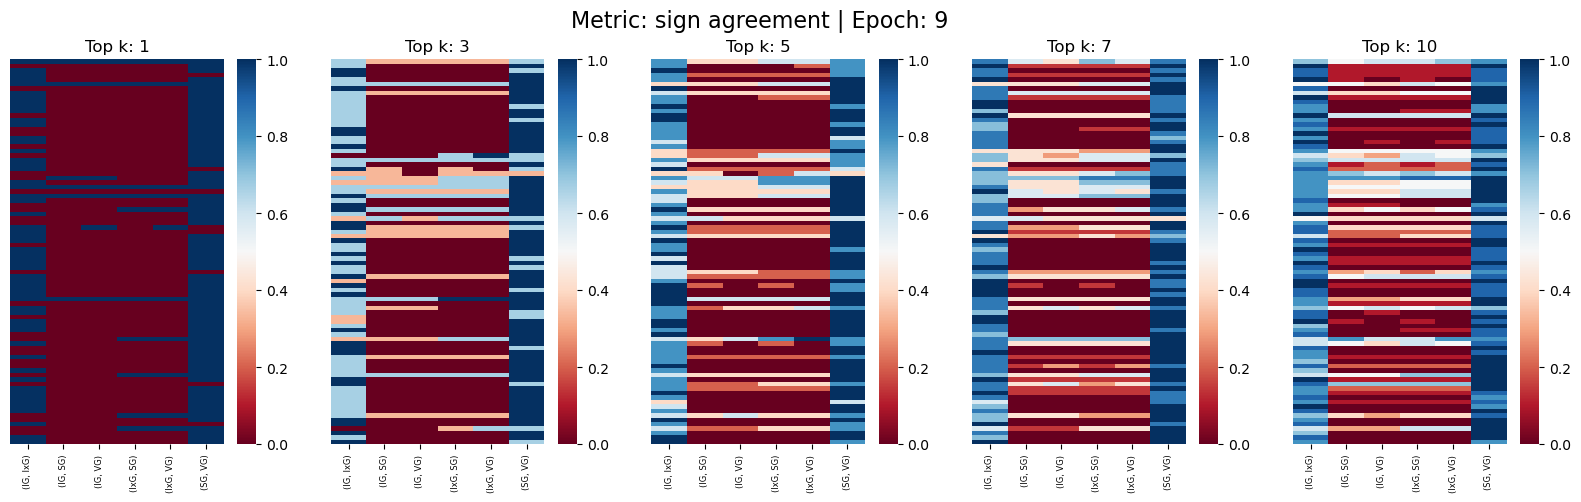

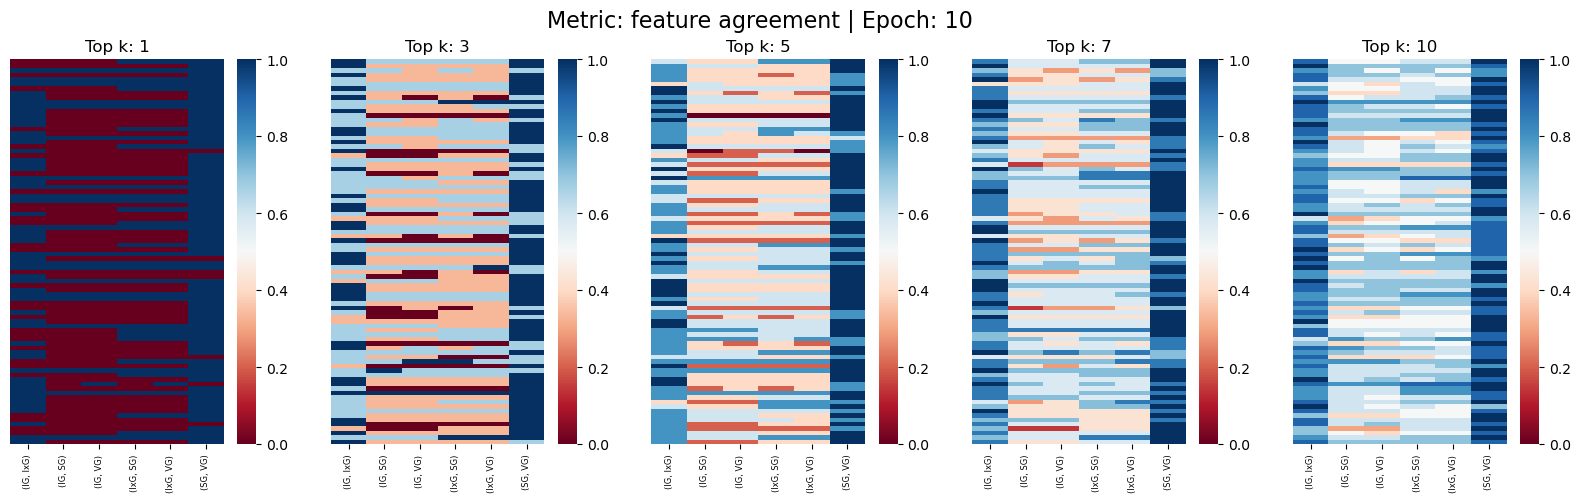

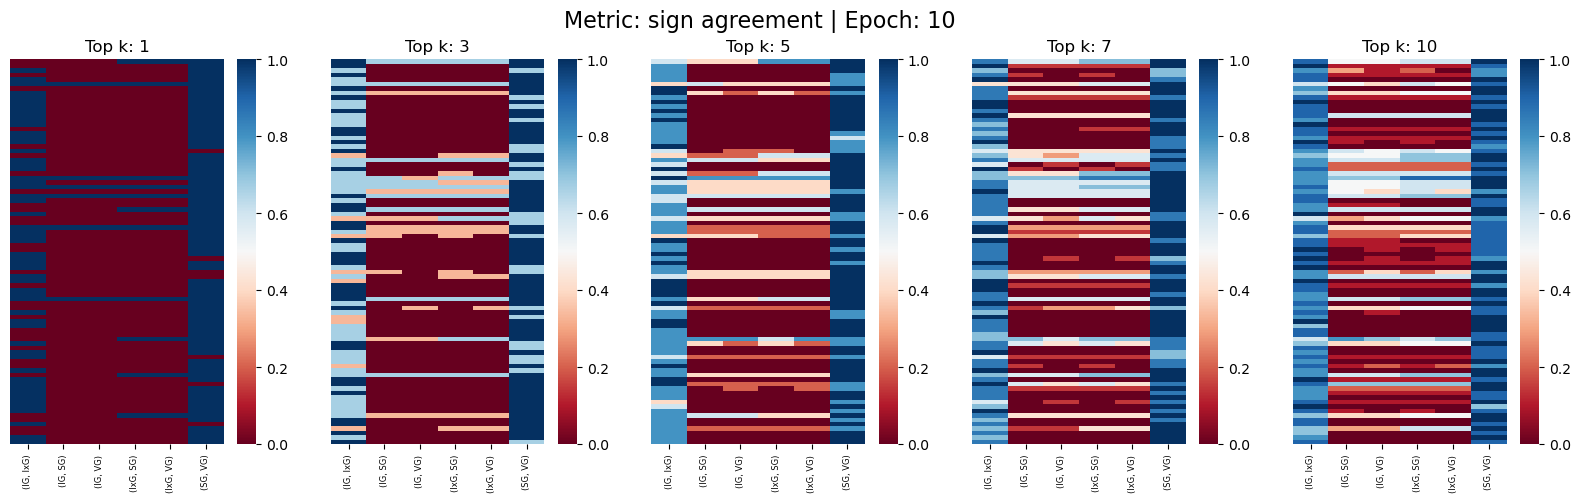

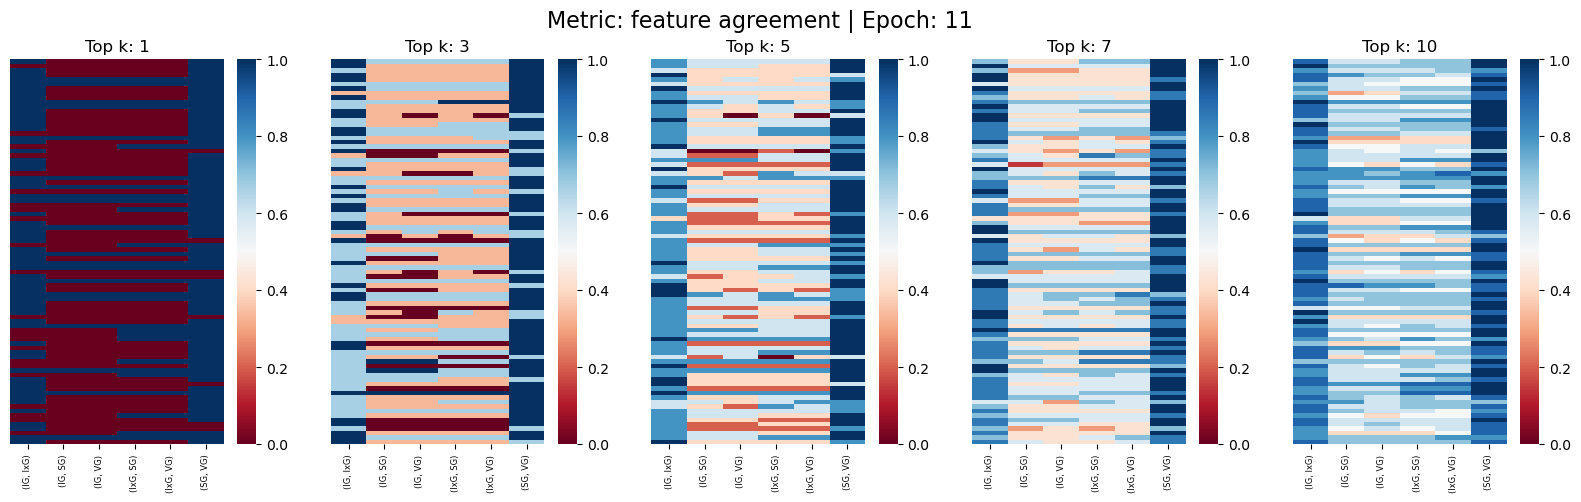

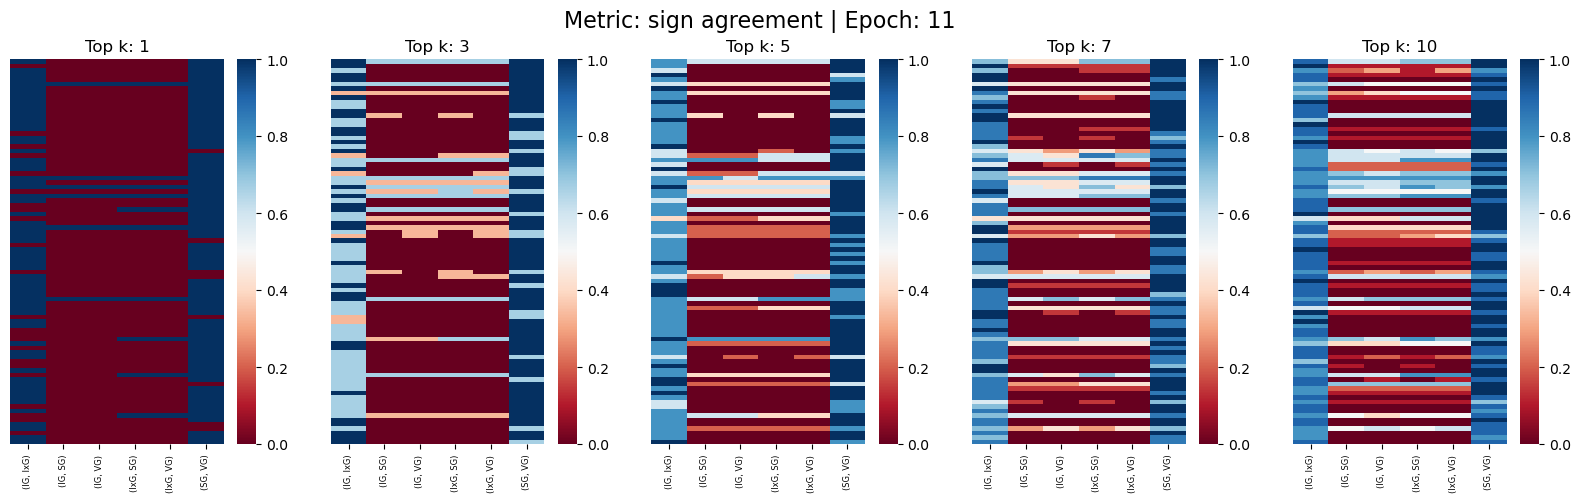

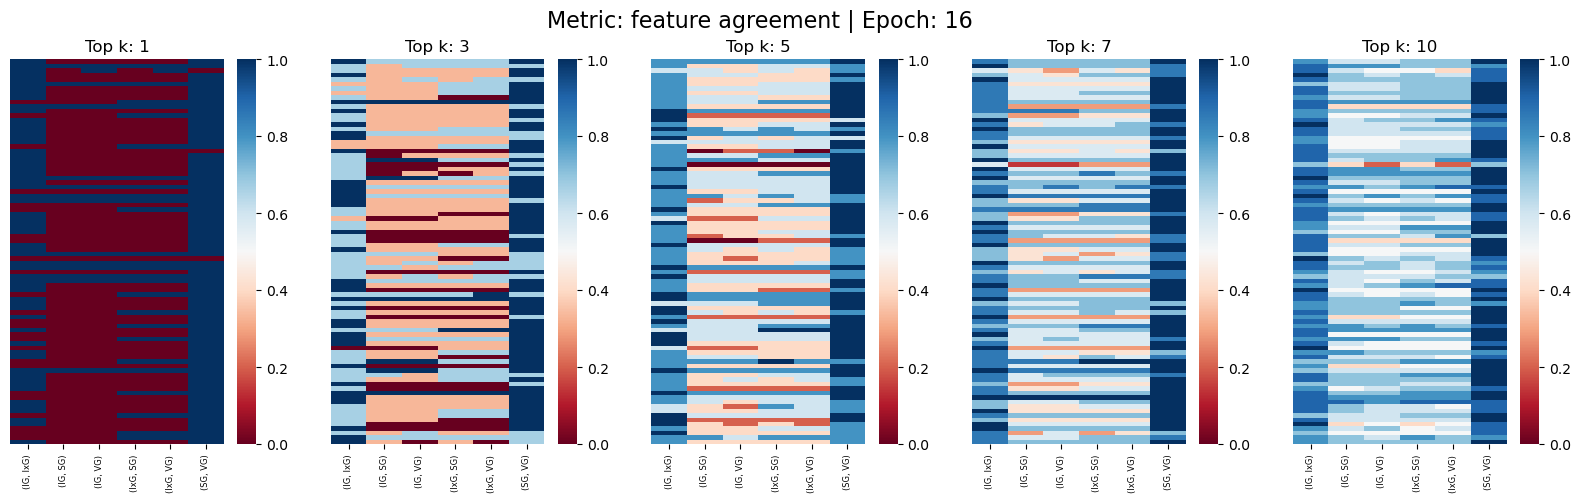

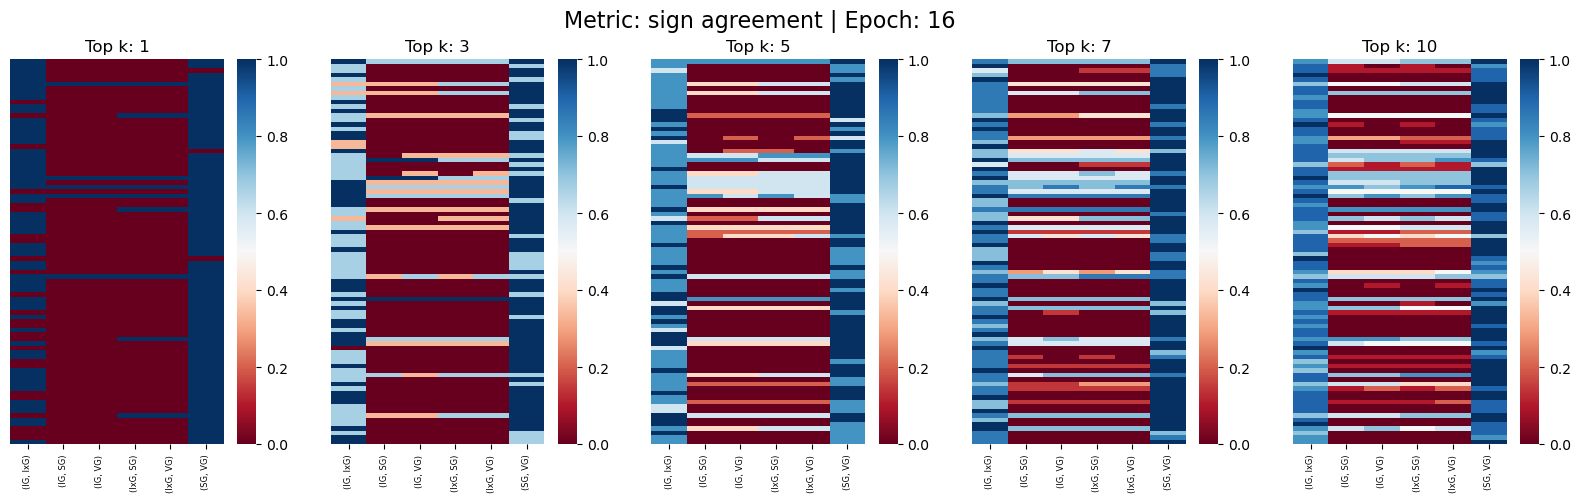

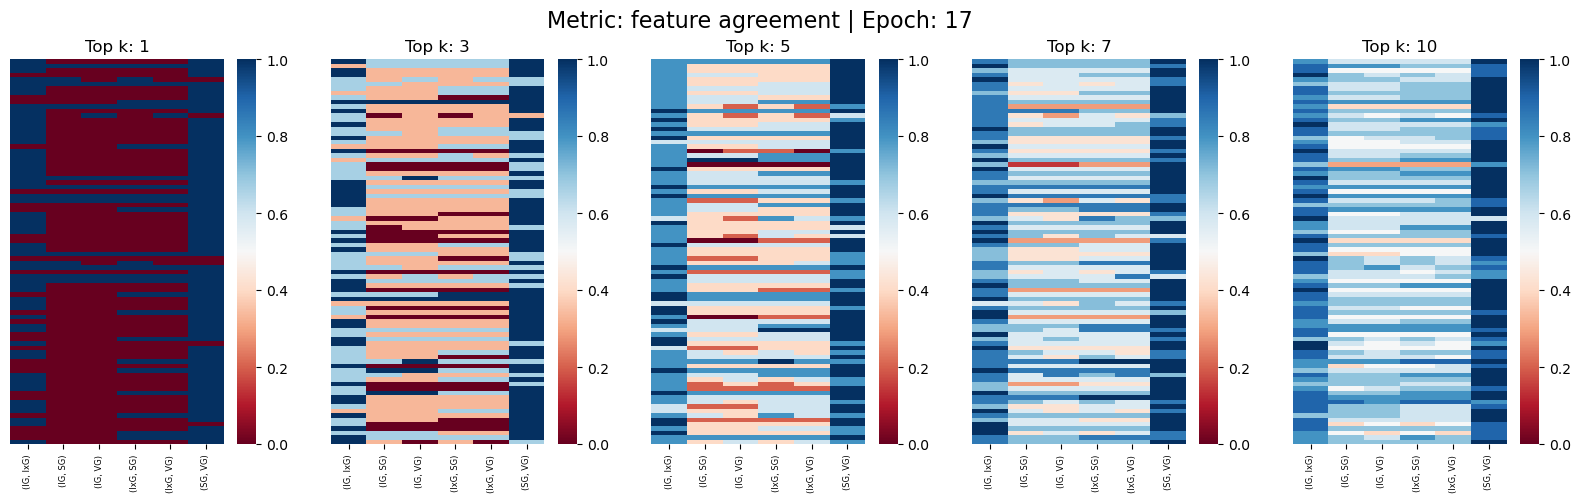

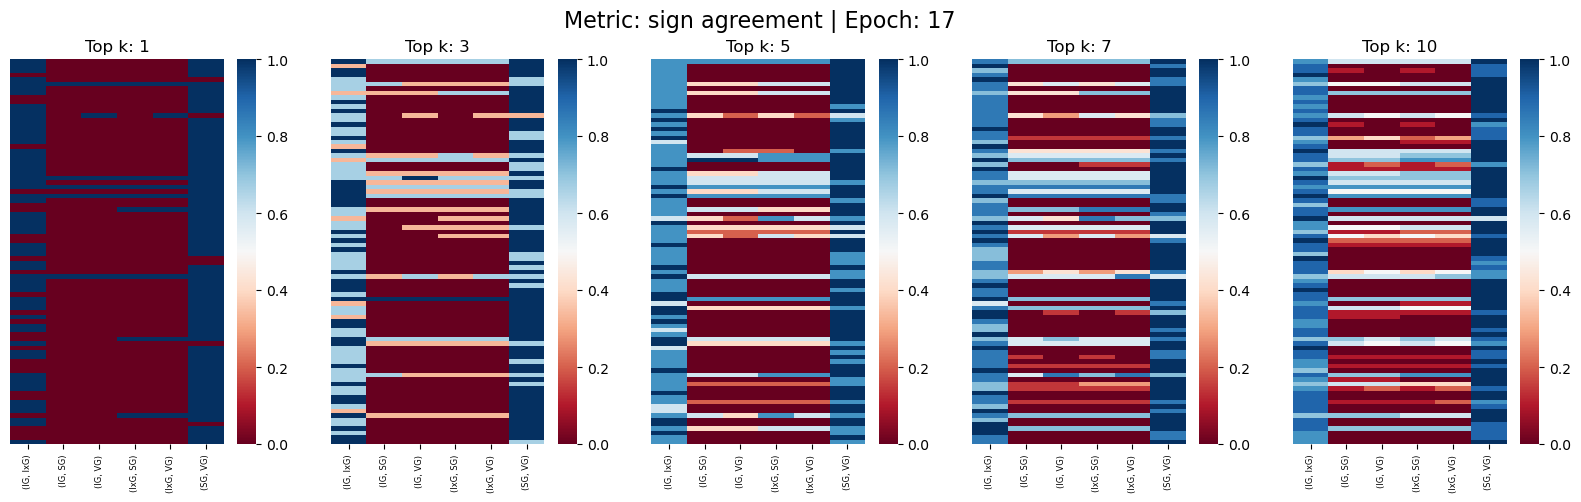

In [23]:
dfs_epochs = {}
for epoch in selected_epochs:
    dfs_metrics = {}
    selected_methods = [explanation_methods[0], explanation_methods[1], explanation_methods[2], explanation_methods[3]]
    for metric_name, selected_metric in list_metrics.items():
        fig, axs = plt.subplots(1, 5, figsize=(20, 5))
        i = 0
        df_k = {}
        for selected_k in [1,3,5,7,10]:
            dict_topk = get_dict_topk(attributions[epoch], explanation_methods, selected_k)
            matrix_points, list_combinations_methods = calc_metrics(selected_k, selected_methods, selected_metric, dict_topk)
            xticklabels = ['(IG, IxG)', '(IG, SG)', '(IG, VG)', '(IxG, SG)', '(IxG, VG)', '(SG, VG)']
            name_combinations_methods = [str(t) for t in list_combinations_methods]
            df = pd.DataFrame(matrix_points, columns=name_combinations_methods)

            df_k[selected_k] = df
            
            sns.heatmap(df, cmap='RdBu', ax=axs[i], vmax=1, vmin=0, xticklabels=xticklabels)
            axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 90, fontsize = 6)
            axs[i].get_yaxis().set_visible(False)
            axs[i].set_title('Top k: ' + str(selected_k))
            
            i+=1
            
        dfs_metrics[metric_name] = df_k
        fig.suptitle('Metric: ' + metric_name + ' | Epoch: ' + str(epoch), fontsize=16)
        plt.show()
    dfs_epochs[epoch] = dfs_metrics
            

In [28]:
dfs_epochs.keys(), dfs_epochs[17].keys(), dfs_epochs[17]['feature agreement'].keys()

(dict_keys([1, 5, 6, 7, 8, 9, 10, 11, 16, 17]),
 dict_keys(['feature agreement', 'sign agreement']),
 dict_keys([1, 3, 5, 7, 10]))

In [49]:
print(max(attributions[1]['Integrated_Gradients'].loc[31], key=abs))
attributions[1]['Integrated_Gradients'].loc[31]

-0.0102051876930851


radius_mean                0.000161
texture_mean               0.000569
perimeter_mean            -0.000389
area_mean                 -0.002278
smoothness_mean           -0.010205
compactness_mean          -0.004600
concavity_mean            -0.000101
concave points_mean       -0.002208
symmetry_mean             -0.001121
fractal_dimension_mean    -0.004507
radius_se                  0.000931
texture_se                 0.004000
perimeter_se              -0.001651
area_se                   -0.001000
smoothness_se             -0.000141
compactness_se             0.002758
concavity_se              -0.003246
concave points_se         -0.004613
symmetry_se                0.000371
fractal_dimension_se      -0.002182
radius_worst              -0.001230
texture_worst             -0.005357
perimeter_worst            0.003478
area_worst                 0.004885
smoothness_worst          -0.003010
compactness_worst          0.001294
concavity_worst            0.003393
concave points_worst       0

In [50]:
print(max(attributions[1]['SmoothGrad'].loc[31], key=abs))
attributions[1]['SmoothGrad'].loc[31]

0.009329237


radius_mean               -0.000675
texture_mean               0.000028
perimeter_mean             0.002536
area_mean                  0.005350
smoothness_mean            0.009329
compactness_mean           0.001632
concavity_mean             0.000402
concave points_mean        0.002163
symmetry_mean              0.000715
fractal_dimension_mean     0.006102
radius_se                 -0.000642
texture_se                -0.000701
perimeter_se               0.007456
area_se                    0.003000
smoothness_se              0.002519
compactness_se            -0.004950
concavity_se               0.006302
concave points_se          0.004659
symmetry_se                0.003399
fractal_dimension_se       0.004027
radius_worst              -0.000721
texture_worst              0.004926
perimeter_worst           -0.002938
area_worst                -0.005189
smoothness_worst           0.002675
compactness_worst         -0.001197
concavity_worst           -0.004261
concave points_worst      -0

In [33]:
dfs_epochs.keys(), dfs_epochs[17].keys(), dfs_epochs[17]['feature agreement'].keys()

(dict_keys([1, 5, 6, 7, 8, 9, 10, 11, 16, 17]),
 dict_keys(['feature agreement', 'sign agreement']),
 dict_keys([1, 3, 5, 7, 10]))

In [53]:
df_sign = pd.DataFrame(columns=['epoch', 'topk', 'disagree', 'agree'])
for epoch in selected_epochs:
#     print('------------- ' + str(epoch) + ' -------------')
    k = 1
    df_temp = dfs_epochs[epoch]['feature agreement'][k].copy()
    df_temp['mean'] = df_temp.mean(axis=1)
    fa_list = df_temp[df_temp['mean'] > 0.9].index.values
#     print('Qnt de instâncias com 100% de concordância em FA:' + str(len(fa_list)))
    
    df_temp = dfs_epochs[epoch]['sign agreement'][k].copy()
    df_temp['mean'] = df_temp.mean(axis=1)
    sa_list = df_temp[df_temp['mean'] > 0.9].index.values
#     print('Qnt de instâncias com 100% de concordância em S:' + str(len(sa_list)))
    
#     print('Instâncias que discordam o sinal no top 1: ')
    list_disagree = list(set(fa_list)-set(sa_list))
#     print(list_disagree)
    
#     print('Instâncias que concordam o sinal no top 1: ')
    list_agree = list(set(fa_list).intersection(set(sa_list)))
#     print(list_agree)
    
     # Define the new row to be added
    new_row = {'epoch': epoch, 'topk': k, 'disagree': list_disagree, 'agree': list_agree}

    # Use the loc method to add the new row to the DataFrame
    df_sign.loc[len(df_sign)] = new_row

In [55]:
df_sign['methods'] = 'GradientBased'
df_sign

,epoch,topk,disagree,agree,methods
0,1,1,"[67, 69, 14, 85, 59, 60, 31]","[33, 66, 35, 71, 7, 45, 79, 48, 22, 54, 24, 27]",GradientBased
1,5,1,"[65, 2, 69, 6, 10, 43, 74, 14, 46, 49, 84, 59]","[24, 25, 28, 21]",GradientBased
2,6,1,"[2, 37, 6, 69, 10, 11, 43, 45, 46, 74, 49, 52,...","[20, 53, 22, 24, 26, 28, 30]",GradientBased
3,7,1,"[2, 37, 6, 69, 9, 10, 11, 43, 45, 46, 74, 17, ...","[0, 53, 22, 24, 26, 28, 30]",GradientBased
4,8,1,"[2, 69, 6, 9, 10, 11, 43, 74, 46, 49, 52, 84, ...","[0, 5, 53, 26, 28, 30]",GradientBased
5,9,1,"[2, 4, 69, 9, 10, 43, 74, 45, 46, 17, 49, 52, ...","[0, 5, 53, 28, 30]",GradientBased
6,10,1,"[2, 4, 69, 9, 10, 43, 74, 45, 46, 17, 49, 52, ...","[5, 37, 53, 26, 28, 30]",GradientBased
7,11,1,"[4, 69, 9, 10, 43, 74, 45, 46, 17, 49, 52, 84,...","[5, 37, 53, 26, 28, 30]",GradientBased
8,16,1,"[1, 69, 10, 43, 45, 46, 49, 31]","[5, 48, 26, 28, 30]",GradientBased
9,17,1,"[1, 10, 43, 46, 49, 31]","[5, 48, 26, 28, 30]",GradientBased


In [57]:
df_sign.to_csv('./data/wdbc/NN/fa_v_sa/fa_v_sa.csv', index=False)

## Case 2: Agnostic explanation methods

In [ ]:
explanation_methods

In [ ]:
selected_methods = [explanation_methods[5], explanation_methods[6], explanation_methods[7], explanation_methods[9]]

dfs = {}

for metric_name, selected_metric in list_metrics.items():
    fig, axs = plt.subplots(1, 5, figsize=(20, 5))
    fig_space, axs_space = plt.subplots(1, 5, figsize=(20, 5))
    fig_boxplot, axs_boxplot = plt.subplots(1, 5, figsize=(20, 5))
    
    i = 0
    df_k = {}
    
    for selected_k in [1,3,5,7,10]:
        dict_topk = get_dict_topk(attr, explanation_methods, selected_k)
        matrix_points, list_combinations_methods = calc_metrics(selected_k, selected_methods, selected_metric, dict_topk)
        xticklabels = ['(OC, LM)', '(OC, KS)', '(OC, SVS)', '(LM, KS)', '(LM, SVS)', '(KS, SVS)']
        name_combinations_methods = [str(t) for t in list_combinations_methods]
        df = pd.DataFrame(matrix_points, columns=name_combinations_methods)
        
        df_k[selected_k] = df
        
        sns.heatmap(df, cmap='RdBu', ax=axs[i], vmax=1, vmin=0, xticklabels=xticklabels)
        axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation = 90, fontsize = 6)
        axs[i].get_yaxis().set_visible(False)
        axs[i].set_title('Top k: ' + str(selected_k))        
        
        _, df_lamp = draw_lamp(matrix_points, axs_space[i])
        axs_space[i].set_title('Top k: ' + str(selected_k))
        
        sns.boxplot(data=df, ax=axs_boxplot[i])
        axs_boxplot[i].set_title('Top k: ' + str(selected_k))      
        axs_boxplot[i].set_xticklabels(xticklabels, rotation = 90, fontsize = 6)
        
        i+=1
        
    dfs[metric_name] = df_k
    fig.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_space.suptitle('Metric: ' + metric_name, fontsize=16)
    fig_boxplot.suptitle('Metric: ' + metric_name, fontsize=16)
    plt.show()

In [ ]:
df_temp = dfs['feature agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9].index.values

In [ ]:
df_temp = dfs['sign agreement'][1].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9]

In [ ]:
df_temp = dfs['feature agreement'][3].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9]

In [ ]:
df_temp = dfs['sign agreement'][3].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.9]

In [ ]:
df_temp = dfs['feature agreement'][5].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.75]

In [ ]:
df_temp = dfs['sign agreement'][5].copy()
df_temp['mean'] = df_temp.mean(axis=1)
df_temp[df_temp['mean'] > 0.75]

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
ax_count = 0

for metric_name, value in dfs.items():
    print(metric_name)
    df_mean = pd.DataFrame(index=dfs[metric_name][1].mean(axis=0).to_frame().index)
    for k in [1,3,5,7,10]:
        print(k)
        print(dfs[metric_name][k].mean(axis=0))
        df_mean[k] = dfs[metric_name][k].mean(axis=0).to_frame(name=k)[k]
    sns.heatmap(df_mean, cmap='Blues', annot=True, vmax=1, vmin=0, ax=axs[ax_count])
    axs[ax_count].set_xlabel('k')
    axs[ax_count].set_title('Metric: ' + metric_name)
    
    df_temp = df_mean.reset_index().melt('index', var_name='k',  value_name='vals')
    sns.catplot(x="k", y="vals", hue='index', data=df_temp, kind='point')
    
    ax_count+=1    
    print('\n\n ---------------------- \n')
plt.plot()